In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import warnings
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import cv2
from pathlib import Path
import math


# Suppress the PyTorch deprecation warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [39]:
"""
====================================================================
PARAMETERS - Centralized Configuration for IM2PROP v2
====================================================================
Modify these parameters to control the entire pipeline.
"""

# ── File Paths ─────────────────────────────────────────────────────
IMAGE_DIR     = Path('dss_2205/image_v2/')
MASK_DIR      = Path('dss_2205/masks_v2/')
CSV_PATH      = Path('dss_2205/hardness_table_image_v2.csv')
CSV_V2_PATH   = Path('dss_2205/hardness_table_image_v2.csv')

# ── CV Pipeline Parameters (Phase Mask Extraction) ─────────────────
MEDIAN_K      = 5                # Median filter kernel
BG_SIGMA      = 80               # Background estimation sigma
CLAHE_CLIP    = 3.0              # CLAHE clip limit
CLAHE_GRID    = (8, 8)           # CLAHE tile size
GAUSS_K       = (5, 5)           # Gaussian smoothing kernel
GAUSS_SIG     = 1                # Gaussian sigma
OPEN_K        = 3                # Opening kernel
OPEN_IT       = 2                # Opening iterations
CLOSE_K       = 5                # Closing kernel
CLOSE_IT      = 2                # Closing iterations
MIN_AREA_PIXELS = 200            # Min area for dark phase regions (filtering)

# ── Dataset Parameters ─────────────────────────────────────────────
IMG_SIZE      = 768              # Full image size
PATCH_SIZE    = 384              # Tile patch size
TRAIN_BATCH   = 8                # Training batch size
VAL_BATCH     = 4                # Validation batch size
TEST_BATCH    = 12               # Test batch size

# ── Training Parameters ────────────────────────────────────────────
NUM_EPOCHS    = 20               # Total training epochs
VAL_FREQUENCY = 2                # Validate every N epochs
LEARNING_RATE = 1e-3             # Adam learning rate
CRITERION     = 'SmoothL1Loss'   # Loss function

# ── Model Parameters ──────────────────────────────────────────────
ENCODER_NAME  = 'resnet50'       # Backbone architecture
WEIGHTS_SOURCE = 'micronet'      # Pre-trained weights source
FREEZE_ENCODER = True            # Freeze encoder during training

# ── Visualization Parameters ──────────────────────────────────────
NUM_VIZ_SAMPLES = 6              # Number of test samples to visualize
VIZ_COLS = 3                     # Columns in visualization grid
ATTENTION_ALPHA = 0.3            # Attention overlay alpha
HEATMAP_ALPHA   = 0.6            # Heatmap overlay alpha
HEATMAP_CMAP    = 'jet'          # Heatmap colormap

# ── Sliding Window Inference Parameters ────────────────────────────
# Design: crop_size MUST equal model_input_size (PATCH_SIZE) to avoid resizing artifacts
# The sliding window uses GCD approach: ensures every patch contains useful information
# stride options: 384 (non-overlapping, efficient) or 192 (overlapping, smoother predictions)
SLIDING_WINDOW_CROP_SIZE = (384, 384)   # Window size (must equal PATCH_SIZE)
SLIDING_WINDOW_INPUT_SIZE = (384, 384)  # Model input size (enforced = crop_size)
SLIDING_WINDOW_STRIDE = 192              # Step size: 384 (no overlap) or 192 (50% overlap)
SLIDING_WINDOW_MODE = 'overlapping'      # 'overlapping' or 'non-overlapping'
INFERENCE_IMAGE_PATH = 'dss_2205/10X.png'  # Image path for inference

print(f"\n{'='*60}")
print("IM2PROP v2 - Centralized Parameters Loaded")
print(f"{'='*60}")
print(f"Image directory: {IMAGE_DIR}")
print(f"Mask directory: {MASK_DIR}")
print(f"Training epochs: {NUM_EPOCHS}, Validation freq: {VAL_FREQUENCY}")
print(f"Batch sizes - Train: {TRAIN_BATCH}, Val: {VAL_BATCH}, Test: {TEST_BATCH}")
print(f"Sliding window - Crop: {SLIDING_WINDOW_CROP_SIZE}, Stride: {SLIDING_WINDOW_STRIDE}, Mode: {SLIDING_WINDOW_MODE}")
print(f"{'='*60}\n")


IM2PROP v2 - Centralized Parameters Loaded
Image directory: dss_2205/image_v2
Mask directory: dss_2205/masks_v2
Training epochs: 20, Validation freq: 2
Batch sizes - Train: 8, Val: 4, Test: 12
Sliding window - Crop: (384, 384), Stride: 192, Mode: overlapping



In [19]:
"""
STEP 1: Offline Pre-computation
================================
Extracts phase masks from all images using CV pipeline.
Saves masks and creates augmented hardness_table_v2.csv with phase ratios.

Parameters used from the centralized config above.
"""

# Create mask directory
MASK_DIR.mkdir(exist_ok=True, parents=True)

def extract_phase_mask(img_path):
    """
    Applies the complete CV pipeline to extract binary phase mask.
    Returns:
        mask_filtered: binary mask [H, W] where 255=light phase, 0=dark phase
        light_ratio: float, light phase percentage (0-100)
        dark_ratio: float, dark phase percentage (0-100)
    """
    # Load
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        raise ValueError(f"Cannot read image: {img_path}")
    
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # --- Preprocessing ---
    # 1. Median filter
    img_med = cv2.medianBlur(img_gray, MEDIAN_K)
    
    # 2. Background subtraction
    bg = cv2.GaussianBlur(img_med, (0, 0), BG_SIGMA).astype(np.float32)
    bg = np.clip(bg, 1, None)
    img_norm = (img_med.astype(np.float32) / bg * 128).clip(0, 255).astype(np.uint8)
    
    # 3. CLAHE
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID)
    img_clahe = clahe.apply(img_norm)
    
    # 4. Gaussian blur
    img_smooth = cv2.GaussianBlur(img_clahe, GAUSS_K, GAUSS_SIG)
    
    # --- Thresholding ---
    otsu_val, mask_otsu = cv2.threshold(
        img_smooth, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    
    # --- Morphological Cleaning ---
    open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (OPEN_K, OPEN_K))
    close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (CLOSE_K, CLOSE_K))
    
    mask_opened = cv2.morphologyEx(mask_otsu, cv2.MORPH_OPEN, open_kernel, iterations=OPEN_IT)
    mask_clean = cv2.morphologyEx(mask_opened, cv2.MORPH_CLOSE, close_kernel, iterations=CLOSE_IT)
    
    # --- Area Filtering ---
    dark_phase_mask = (mask_clean == 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(dark_phase_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    mask_filtered = mask_clean.copy()
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < MIN_AREA_PIXELS:
            cv2.drawContours(mask_filtered, [contour], 0, 255, -1)
    
    # --- Calculate Phase Ratios ---
    light_pixels = np.sum(mask_filtered == 255)
    dark_pixels = np.sum(mask_filtered == 0)
    total_pixels = mask_filtered.size
    
    light_ratio = (light_pixels / total_pixels) * 100.0
    dark_ratio = (dark_pixels / total_pixels) * 100.0
    
    return mask_filtered, light_ratio, dark_ratio

# --- Main Processing Loop ---
print("Starting offline pre-computation...")
print(f"Image directory: {IMAGE_DIR}")
print(f"Mask output directory: {MASK_DIR}")

# Read existing CSV
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} images from {CSV_PATH}")

# Add new columns
df['light_phase_ratio'] = 0.0
df['dark_phase_ratio'] = 0.0

light_ratios = []
dark_ratios = []
failed_images = []

# Process each image
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting phase masks"):
    img_id = row['image_id']
    img_path = IMAGE_DIR / f"{img_id}.png"
    
    try:
        # Extract mask
        mask, light_ratio, dark_ratio = extract_phase_mask(img_path)
        
        # Save mask as PNG (uint8, more compatible)
        mask_path = MASK_DIR / f"{img_id}_mask.png"
        cv2.imwrite(str(mask_path), mask)
        
        light_ratios.append(light_ratio)
        dark_ratios.append(dark_ratio)
        
    except Exception as e:
        print(f"\n❌ Error processing {img_id}: {e}")
        failed_images.append(img_id)
        light_ratios.append(np.nan)
        dark_ratios.append(np.nan)

# Update dataframe
df['light_phase_ratio'] = light_ratios
df['dark_phase_ratio'] = dark_ratios

# Save augmented CSV
df.to_csv(CSV_V2_PATH, index=False)
print(f"\n✅ Saved augmented CSV: {CSV_V2_PATH}")
print(f"Phase ratios added: light_phase_ratio, dark_phase_ratio")

# Summary
print(f"\n--- Processing Summary ---")
print(f"Total images processed: {len(df) - len(failed_images)}")
print(f"Failed: {len(failed_images)}")
if failed_images:
    print(f"Failed images: {failed_images}")
    
print(f"\nPhase Ratio Statistics:")
print(f"Light Phase - Mean: {df['light_phase_ratio'].mean():.2f}%, Std: {df['light_phase_ratio'].std():.2f}%")
print(f"Dark Phase  - Mean: {df['dark_phase_ratio'].mean():.2f}%, Std: {df['dark_phase_ratio'].std():.2f}%")

# Quick sanity check
print(f"\nSample (first 3 rows):")
print(df[['image_id', 'light_phase_ratio', 'dark_phase_ratio']].head(3))

Starting offline pre-computation...
Image directory: dss_2205/image_v2
Mask output directory: dss_2205/masks_v2
Loaded 20 images from dss_2205/hardness_table_image_v2.csv


Extracting phase masks: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


✅ Saved augmented CSV: dss_2205/hardness_table_image_v2.csv
Phase ratios added: light_phase_ratio, dark_phase_ratio

--- Processing Summary ---
Total images processed: 20
Failed: 0

Phase Ratio Statistics:
Light Phase - Mean: 70.12%, Std: 5.30%
Dark Phase  - Mean: 29.88%, Std: 5.30%

Sample (first 3 rows):
  image_id  light_phase_ratio  dark_phase_ratio
0     HO_1          72.230360         27.769640
1     HO_2          71.879917         28.120083
2     HO_3          76.515028         23.484972


In [20]:
# image augmentations
train_augmentations = transforms.Compose([
    transforms.ToTensor(),
])

test_augmentations = transforms.Compose([
    transforms.ToTensor(),
])

In [21]:
"""
STEP 2: IM2PROPDataset_V2 - Dual-Branch Dataset
================================================
Loads RGB tiles AND phase mask tiles with aligned tiling logic.
Returns: (rgb_tile, mask_tile, phase_ratios, target)

Uses IMG_SIZE and PATCH_SIZE from parameters above.
"""

class IM2PROPDataset_V2(Dataset):
    """
    Dual-branch dataset: RGB image + Phase mask + Phase ratios.
    Tiles each 768x768 image into 4 patches of 384x384 (TL, TR, BL, BR).
    Ensures spatial alignment between RGB and phase mask tiles.
    """
    
    # Use global parameters
    img_size = IMG_SIZE
    patch_size = PATCH_SIZE
    
    # Generate tiling boxes
    BOXES = [
        (x, y, x + PATCH_SIZE, y + PATCH_SIZE)
        for y in range(0, IMG_SIZE, PATCH_SIZE)
        for x in range(0, IMG_SIZE, PATCH_SIZE)
    ]
    
    def __init__(self, csv_data, image_dir, mask_dir, transform_rgb=None, transform_mask=None, return_info=False):
        """
        Args:
            csv_data: DataFrame with columns [image_id, avg_hardness_round, light_phase_ratio, dark_phase_ratio]
            image_dir: path to RGB images
            mask_dir: path to phase masks
            transform_rgb: transforms for RGB tiles
            transform_mask: transforms for mask tiles (optional)
            return_info: if True, also return (img_name, patch_id)
        """
        self.data = csv_data.reset_index(drop=True)
        self.img_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform_rgb = transform_rgb
        self.transform_mask = transform_mask
        self.return_info = return_info
    
    def __len__(self):
        # 4 tiles per base image
        return len(self.data) * ((self.img_size // self.patch_size) ** 2)
    
    def __getitem__(self, idx):
        base_idx = idx // ((self.img_size // self.patch_size) ** 2)
        patch_id = idx % ((self.img_size // self.patch_size) ** 2)
        
        row = self.data.iloc[base_idx]
        img_name = row['image_id']
        target = row['avg_hardness_round']
        light_ratio = row['light_phase_ratio']
        dark_ratio = row['dark_phase_ratio']
        
        # --- Load RGB Image ---
        img_path = self.img_dir / f"{img_name}.png"
        rgb_image = Image.open(img_path).convert("RGB")
        
        # --- Load Phase Mask ---
        mask_path = self.mask_dir / f"{img_name}_mask.png"
        phase_mask = Image.open(mask_path).convert("L")  # Grayscale
        
        # --- Crop using the SAME BOXES for spatial alignment ---
        box = self.BOXES[patch_id]
        rgb_tile = rgb_image.crop(box)      # [384, 384, 3]
        mask_tile = phase_mask.crop(box)    # [384, 384]
        
        # --- Apply Transforms ---
        if self.transform_rgb:
            rgb_tile = self.transform_rgb(rgb_tile)  # -> [3, 384, 384]
        else:
            rgb_tile = transforms.ToTensor()(rgb_tile)
        
        if self.transform_mask:
            mask_tile = self.transform_mask(mask_tile)  # -> [1, 384, 384]
        else:
            # Manual conversion to tensor + add channel dimension
            mask_tile = torch.from_numpy(np.array(mask_tile, dtype=np.float32)).unsqueeze(0)  # [1, 384, 384]
        
        # Normalize mask to [0, 1] range
        mask_tile = mask_tile / 255.0
        
        # --- Create Phase Ratio Tensor ---
        phase_ratios = torch.tensor([light_ratio / 100.0, dark_ratio / 100.0], dtype=torch.float32)
        
        # --- Target ---
        target = torch.tensor(target, dtype=torch.float32)
        
        if self.return_info:
            return rgb_tile, mask_tile, phase_ratios, target, (img_name, patch_id)
        return rgb_tile, mask_tile, phase_ratios, target

In [23]:
print("Loading augmented CSV with phase ratios...")
df_v2 = pd.read_csv(CSV_V2_PATH)

random_state = random.randint(0, 10000)
train_val_df, test_df = train_test_split(df_v2, test_size=0.2, random_state=random_state)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=random_state)

# Create dual-branch datasets
train_dataset = IM2PROPDataset_V2(
    train_df,
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    transform_rgb=train_augmentations,
    transform_mask=None
)
val_dataset = IM2PROPDataset_V2(
    val_df,
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    transform_rgb=test_augmentations,
    transform_mask=None
)
test_dataset = IM2PROPDataset_V2(
    test_df,
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    transform_rgb=test_augmentations,
    transform_mask=None
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples  : {len(val_dataset)}")
print(f"Test samples : {len(test_dataset)}")

# Quick sanity check: peek at one batch
print("\n✅ Dual-branch datasets created!")
print("Peeking at one training batch (will create after dataloaders)...")

Loading augmented CSV with phase ratios...
Train samples: 48
Val samples  : 16
Test samples : 16

✅ Dual-branch datasets created!
Peeking at one training batch (will create after dataloaders)...


In [24]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH, shuffle=False)

# Quick sanity check: peek at one batch
print("Peeking at one training batch:")
rgb_tile, mask_tile, phase_ratios, target = next(iter(train_loader))
print(f"  RGB tile shape:      {rgb_tile.shape}  (expected: [B, 3, 384, 384])")
print(f"  Mask tile shape:     {mask_tile.shape}  (expected: [B, 1, 384, 384])")
print(f"  Phase ratios shape:  {phase_ratios.shape}  (expected: [B, 2])")
print(f"  Target shape:        {target.shape}  (expected: [B])")

Peeking at one training batch:
  RGB tile shape:      torch.Size([8, 3, 384, 384])  (expected: [B, 3, 384, 384])
  Mask tile shape:     torch.Size([8, 1, 384, 384])  (expected: [B, 1, 384, 384])
  Phase ratios shape:  torch.Size([8, 2])  (expected: [B, 2])
  Target shape:        torch.Size([8])  (expected: [B])


In [25]:
"""
STEP 3: IM2PROP v2 - Physics-Informed Dual-Branch Architecture
===============================================================
Combines:
  - SpatialAttention: learns attention on frozen ResNet50 features
  - PhaseCNN: extracts topology features from phase mask
  - MLP Regression Head: integrates both branches

Uses ENCODER_NAME, WEIGHTS_SOURCE, and FREEZE_ENCODER from parameters above.
"""

class SpatialAttention(nn.Module):
    """
    Lightweight spatial attention module.
    Input: [B, 2048, H, W]
    Output: [B, 2048] (after GAP of attended features)
    
    The attention map multiplies element-wise with input features,
    then global average pooling extracts spatial-aggregated features.
    """
    def __init__(self, in_channels=2048):
        super().__init__()
        
        # Attention pathway: 1x1 convolutions to generate attention map
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 1, kernel_size=1, bias=True),  # Output: [B, 1, H, W]
            nn.Sigmoid()  # Attention weights in [0, 1]
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(self, x):
        """
        Args:
            x: [B, 2048, H, W]
        Returns:
            output: [B, 2048]
        """
        # Generate attention map [B, 1, H, W]
        attn = self.attention(x)
        
        # Apply attention: element-wise multiplication
        attended_features = x * attn  # [B, 2048, H, W]
        
        # Global average pooling
        pooled = self.avgpool(attended_features)  # [B, 2048, 1, 1]
        output = torch.flatten(pooled, 1)  # [B, 2048]
        
        return output


class PhaseCNN(nn.Module):
    """
    Extracts topological features from binary phase mask.
    Input: [B, 1, 384, 384]
    Output: [B, 128]
    
    A simple 3-layer CNN with conv -> BN -> ReLU -> MaxPool pattern.
    """
    def __init__(self, output_dim=128):
        super().__init__()
        
        self.features = nn.Sequential(
            # Layer 1: Conv 1 -> 32
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [B, 32, 192, 192]
            
            # Layer 2: Conv 32 -> 64
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [B, 64, 96, 96]
            
            # Layer 3: Conv 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [B, 128, 48, 48]
        )
        
        # Global Average Pooling + FC layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(128, output_dim),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        """
        Args:
            x: [B, 1, 384, 384]
        Returns:
            output: [B, 128]
        """
        # Extract features
        x = self.features(x)  # [B, 128, 48, 48]
        
        # Global average pooling
        x = self.avgpool(x)  # [B, 128, 1, 1]
        x = torch.flatten(x, 1)  # [B, 128]
        
        # Classifier
        output = self.classifier(x)  # [B, 128]
        
        return output


class MicroNetRegressor_V2(nn.Module):
    """
    IM2PROP v2: Dual-branch physics-informed architecture.
    
    Branches:
    1. Spatial-Attention branch: ResNet50 frozen encoder + attention
    2. Phase-topology branch: PhaseCNN from binary mask + phase ratios
    
    Integration:
    - Phase vector: [phase_ratios (2) + mask_features (128)] = [130]
    - Combined: [attention_features (2048) + phase_vector (130)] = [2178]
    - Output: MLP regression head -> [1]
    """
    def __init__(self, pre_trained_base_model):
        super().__init__()
        
        # --- BRANCH 1: Spatial Attention on Frozen ResNet50 ---
        self.encoder_features = nn.Sequential(
            pre_trained_base_model.conv1,
            pre_trained_base_model.bn1,
            pre_trained_base_model.relu,
            pre_trained_base_model.maxpool,
            pre_trained_base_model.layer1,
            pre_trained_base_model.layer2,
            pre_trained_base_model.layer3,
            pre_trained_base_model.layer4
        )
        
        self.spatial_attention = SpatialAttention(in_channels=2048)
        
        # --- BRANCH 2: Phase CNN + Ratio Integration ---
        self.phase_cnn = PhaseCNN(output_dim=128)
        
        # --- MLP REGRESSION HEAD ---
        # Input size: attention_features (2048) + phase_cnn (128) + phase_ratios (2) = 2178
        self.regressor = nn.Sequential(
            nn.Linear(2178, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, 1)  # Final output: scalar hardness
        )
    
    def forward(self, rgb_img, phase_mask, phase_ratios):
        """
        Args:
            rgb_img: [B, 3, 384, 384] - RGB image tile
            phase_mask: [B, 1, 384, 384] - Binary phase mask
            phase_ratios: [B, 2] - [light_ratio, dark_ratio] normalized to [0, 1]
        
        Returns:
            output: [B, 1] - predicted hardness
        """
        # --- BRANCH 1: RGB via ResNet50 + Spatial Attention ---
        rgb_features = self.encoder_features(rgb_img)  # [B, 2048, 12, 12]
        attended_features = self.spatial_attention(rgb_features)  # [B, 2048]
        
        # --- BRANCH 2: Phase Mask via PhaseCNN ---
        mask_features = self.phase_cnn(phase_mask)  # [B, 128]
        
        # --- INTEGRATION: Concatenate phase vector ---
        phase_vector = torch.cat([phase_ratios, mask_features], dim=1)  # [B, 2+128=130]
        
        # --- INTEGRATION: Concatenate all features ---
        combined_features = torch.cat([attended_features, phase_vector], dim=1)  # [B, 2048+130=2178]
        
        # --- MLP Regression Head ---
        output = self.regressor(combined_features)  # [B, 1]
        
        return output


# --- Model Initialization ---
print(f"Loading {ENCODER_NAME} architecture for v2...")
base_model = torch.hub.load('pytorch/vision:v0.10.0', ENCODER_NAME, weights=None)

print(f"Loading MicroNet weights...")
url = pmm.util.get_pretrained_microscopynet_url(encoder=ENCODER_NAME, encoder_weights=WEIGHTS_SOURCE)
base_model.load_state_dict(model_zoo.load_url(url, map_location=device))

# Instantiate v2 model
model_regressor_v2 = MicroNetRegressor_V2(pre_trained_base_model=base_model)
model_regressor_v2 = model_regressor_v2.to(device)

# Freeze ResNet50 encoder if enabled
if FREEZE_ENCODER:
    for name, param in model_regressor_v2.named_parameters():
        if name.startswith('encoder_features'):
            param.requires_grad = False

# Count parameters
total_params = sum(p.numel() for p in model_regressor_v2.parameters())
trainable_params = sum(p.numel() for p in model_regressor_v2.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print("\n--- IM2PROP v2 Model Summary ---")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen (Encoder): {frozen_params:,}")
print(f"\nModel architecture:")
print(f"  ✓ Branch 1 - Spatial Attention (ResNet50): 2048 → 2048 features")
print(f"  ✓ Branch 2 - Phase CNN: 1 channel → 128 features")
print(f"  ✓ Integration: 2048 + 128 + 2 = 2178 features")
print(f"  ✓ MLP Head: 2178 → 1024 → 512 → 256 → 128 → 1")

Loading resnet50 architecture for v2...


Using cache found in /Users/jaychou/.cache/torch/hub/pytorch_vision_v0.10.0


Loading MicroNet weights...

--- IM2PROP v2 Model Summary ---
Total Parameters: 27,116,610
Trainable Parameters: 3,608,578
Frozen (Encoder): 23,508,032

Model architecture:
  ✓ Branch 1 - Spatial Attention (ResNet50): 2048 → 2048 features
  ✓ Branch 2 - Phase CNN: 1 channel → 128 features
  ✓ Integration: 2048 + 128 + 2 = 2178 features
  ✓ MLP Head: 2178 → 1024 → 512 → 256 → 128 → 1


In [26]:
criterion = nn.SmoothL1Loss()  # Using CRITERION parameter from config
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_regressor_v2.parameters()),
    lr=LEARNING_RATE
)

print(f"✅ Optimizer & Criterion configured")
print(f"   Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   Criterion: {CRITERION}")

✅ Optimizer & Criterion configured
   Optimizer: Adam (lr=0.001)
   Criterion: SmoothL1Loss


In [27]:
"""
STEP 4: Training & Validation Loops for Dual-Branch Model
===========================================================
Updated to handle (rgb, mask, ratios, target) from dataloader.
"""

def train_one_epoch_v2(model, dataloader, optimizer, criterion, device):
    """
    Training loop for dual-branch model.
    Unpacks: (rgb_tiles, mask_tiles, phase_ratios, targets)
    """
    model.train()
    running_loss = 0.0
    
    for rgb_tiles, mask_tiles, phase_ratios, targets in tqdm(dataloader, desc="Training", leave=False):
        # Move all tensors to device
        rgb_tiles = rgb_tiles.to(device)
        mask_tiles = mask_tiles.to(device)
        phase_ratios = phase_ratios.to(device)
        targets = targets.to(device).unsqueeze(1)  # [B] -> [B, 1]
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(rgb_tiles, mask_tiles, phase_ratios)  # [B, 1]
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * rgb_tiles.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def validate_one_epoch_v2(model, dataloader, criterion, device):
    """
    Validation loop for dual-branch model.
    Computes loss, MAE, MSE, RMSE.
    """
    model.eval()
    running_loss = 0.0
    preds, trues = [], []
    
    with torch.no_grad():
        for rgb_tiles, mask_tiles, phase_ratios, targets in tqdm(dataloader, desc="Validation", leave=False):
            # Move to device
            rgb_tiles = rgb_tiles.to(device)
            mask_tiles = mask_tiles.to(device)
            phase_ratios = phase_ratios.to(device)
            targets = targets.to(device).unsqueeze(1)  # [B] -> [B, 1]
            
            # Forward pass
            outputs = model(rgb_tiles, mask_tiles, phase_ratios)  # [B, 1]
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * rgb_tiles.size(0)
            
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    preds_concat = np.concatenate(preds).squeeze()
    trues_concat = np.concatenate(trues).squeeze()
    
    mse = np.mean((preds_concat - trues_concat) ** 2)
    mae = np.mean(np.abs(preds_concat - trues_concat))
    rmse = np.sqrt(mse)
    
    return epoch_loss, mae, mse, rmse


Starting IM2PROP v2 Training
Validation every 2 epoch(s)

Epoch [1/20]


Train Loss: 1.6744
(validation skipped - next validation at epoch 2 )

Epoch [2/20]


Train Loss: 1.3173


Val Loss: 1.6925 | Val MAE: 2.1925 | Val RMSE: 2.1927
✅ Saved new best model

Epoch [3/20]


Train Loss: 0.9828
(validation skipped - next validation at epoch 4 )

Epoch [4/20]


Train Loss: 0.6387


Val Loss: 1.2462 | Val MAE: 1.7462 | Val RMSE: 1.7465
✅ Saved new best model

Epoch [5/20]


Train Loss: 0.3436
(validation skipped - next validation at epoch 6 )

Epoch [6/20]


Train Loss: 0.1896


Val Loss: 0.7699 | Val MAE: 1.2699 | Val RMSE: 1.2705
✅ Saved new best model

Epoch [7/20]


Train Loss: 0.0897
(validation skipped - next validation at epoch 8 )

Epoch [8/20]


Train Loss: 0.0913


Val Loss: 0.0988 | Val MAE: 0.4224 | Val RMSE: 0.4445
✅ Saved new best model

Epoch [9/20]


Train Loss: 0.0588
(validation skipped - next validation at epoch 10 )

Epoch [10/20]


Train Loss: 0.0436


Val Loss: 0.2005 | Val MAE: 0.5755 | Val RMSE: 0.6339

Epoch [11/20]


Train Loss: 0.0535
(validation skipped - next validation at epoch 12 )

Epoch [12/20]


Train Loss: 0.0473


Val Loss: 0.0713 | Val MAE: 0.3182 | Val RMSE: 0.3775
✅ Saved new best model

Epoch [13/20]


Train Loss: 0.0406
(validation skipped - next validation at epoch 14 )

Epoch [14/20]


Train Loss: 0.0312


Val Loss: 0.0283 | Val MAE: 0.2030 | Val RMSE: 0.2379
✅ Saved new best model

Epoch [15/20]


Train Loss: 0.0441
(validation skipped - next validation at epoch 16 )

Epoch [16/20]


Train Loss: 0.0593


Val Loss: 0.0066 | Val MAE: 0.0920 | Val RMSE: 0.1147
✅ Saved new best model

Epoch [17/20]


Train Loss: 0.0384
(validation skipped - next validation at epoch 18 )

Epoch [18/20]


Train Loss: 0.0393


Val Loss: 0.0646 | Val MAE: 0.3204 | Val RMSE: 0.3594

Epoch [19/20]


Train Loss: 0.0312
(validation skipped - next validation at epoch 20 )

Epoch [20/20]


Train Loss: 0.0329


Val Loss: 0.0226 | Val MAE: 0.1796 | Val RMSE: 0.2124

Training Complete!


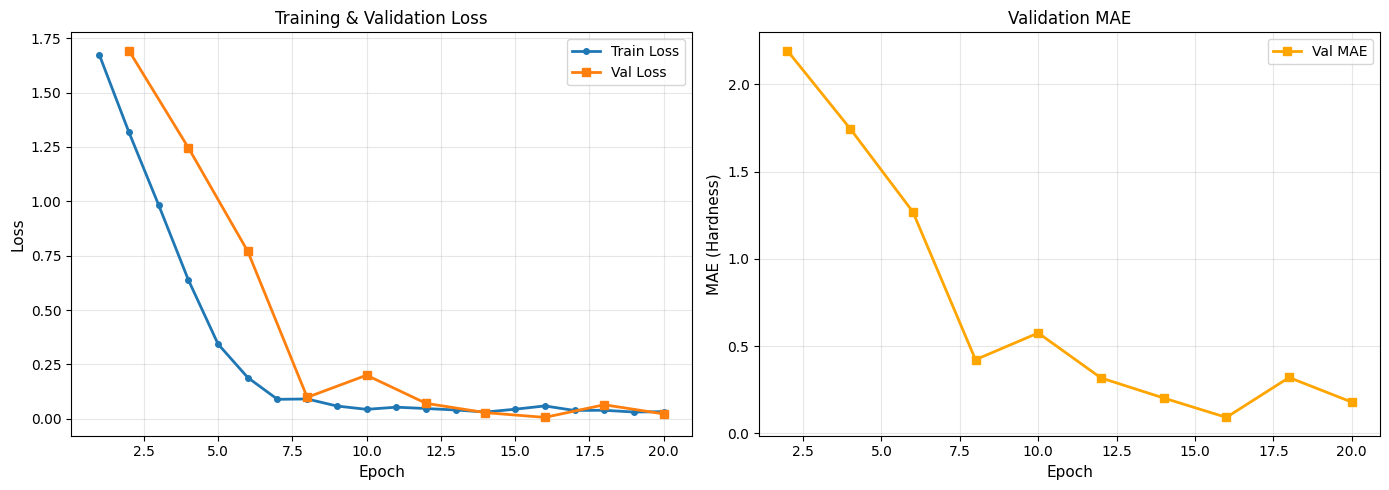


✅ Saved plots to runs/run_20260301_214006
Total training epochs: 20 | Validation frequency: every 2 epoch(s) | Validations performed: 10


In [28]:
# Initialize training
best_val_loss = float('inf')
datetime_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = Path(f"runs/run_{datetime_str}")
run_dir.mkdir(exist_ok=True, parents=True)

hist_train_loss = []
hist_val_loss = []
hist_val_mae = []
hist_epochs_validated = []  # Track which epochs had validation

print(f"\n{'='*60}")
print(f"Starting IM2PROP v2 Training")
print(f"Validation every {VAL_FREQUENCY} epoch(s)")
print(f"{'='*60}")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    
    # Train
    train_loss = train_one_epoch_v2(
        model_regressor_v2, train_loader, optimizer, criterion, device
    )
    hist_train_loss.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Validate only every VAL_FREQUENCY epochs
    if (epoch + 1) % VAL_FREQUENCY == 0:
        val_loss, val_mae, val_mse, rmse = validate_one_epoch_v2(
            model_regressor_v2, val_loader, criterion, device
        )
        
        print(f"Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val RMSE: {rmse:.4f}")
        
        # Record validation metrics
        hist_val_loss.append(val_loss)
        hist_val_mae.append(val_mae)
        hist_epochs_validated.append(epoch + 1)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_regressor_v2.state_dict(), run_dir / "best_regression_model_v2.pt")
            print("✅ Saved new best model")
    else:
        print("(validation skipped - next validation at epoch", ((epoch // VAL_FREQUENCY + 1) * VAL_FREQUENCY), ")")

print("\n" + "="*60)
print("Training Complete!")
print("="*60)

# --- Plot Training Curves ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(range(1, len(hist_train_loss)+1), hist_train_loss, label='Train Loss', linewidth=2, marker='o', markersize=4)
ax1.plot(hist_epochs_validated, hist_val_loss, label='Val Loss', linewidth=2, marker='s', markersize=6)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training & Validation Loss', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# MAE curve
ax2.plot(hist_epochs_validated, hist_val_mae, label='Val MAE', color='orange', linewidth=2, marker='s', markersize=6)
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('MAE (Hardness)', fontsize=11)
ax2.set_title('Validation MAE', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(run_dir / "training_curves.png", dpi=150)
plt.show()

print(f"\n✅ Saved plots to {run_dir}")
print(f"Total training epochs: {NUM_EPOCHS} | Validation frequency: every {VAL_FREQUENCY} epoch(s) | Validations performed: {len(hist_val_loss)}")

Testing with Attention: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]



Test Results (IM2PROP v2 with Attention Maps)
MSE  : 0.0197
MAE  : 0.1051
RMSE : 0.1402


Testing with Attention & Masks: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


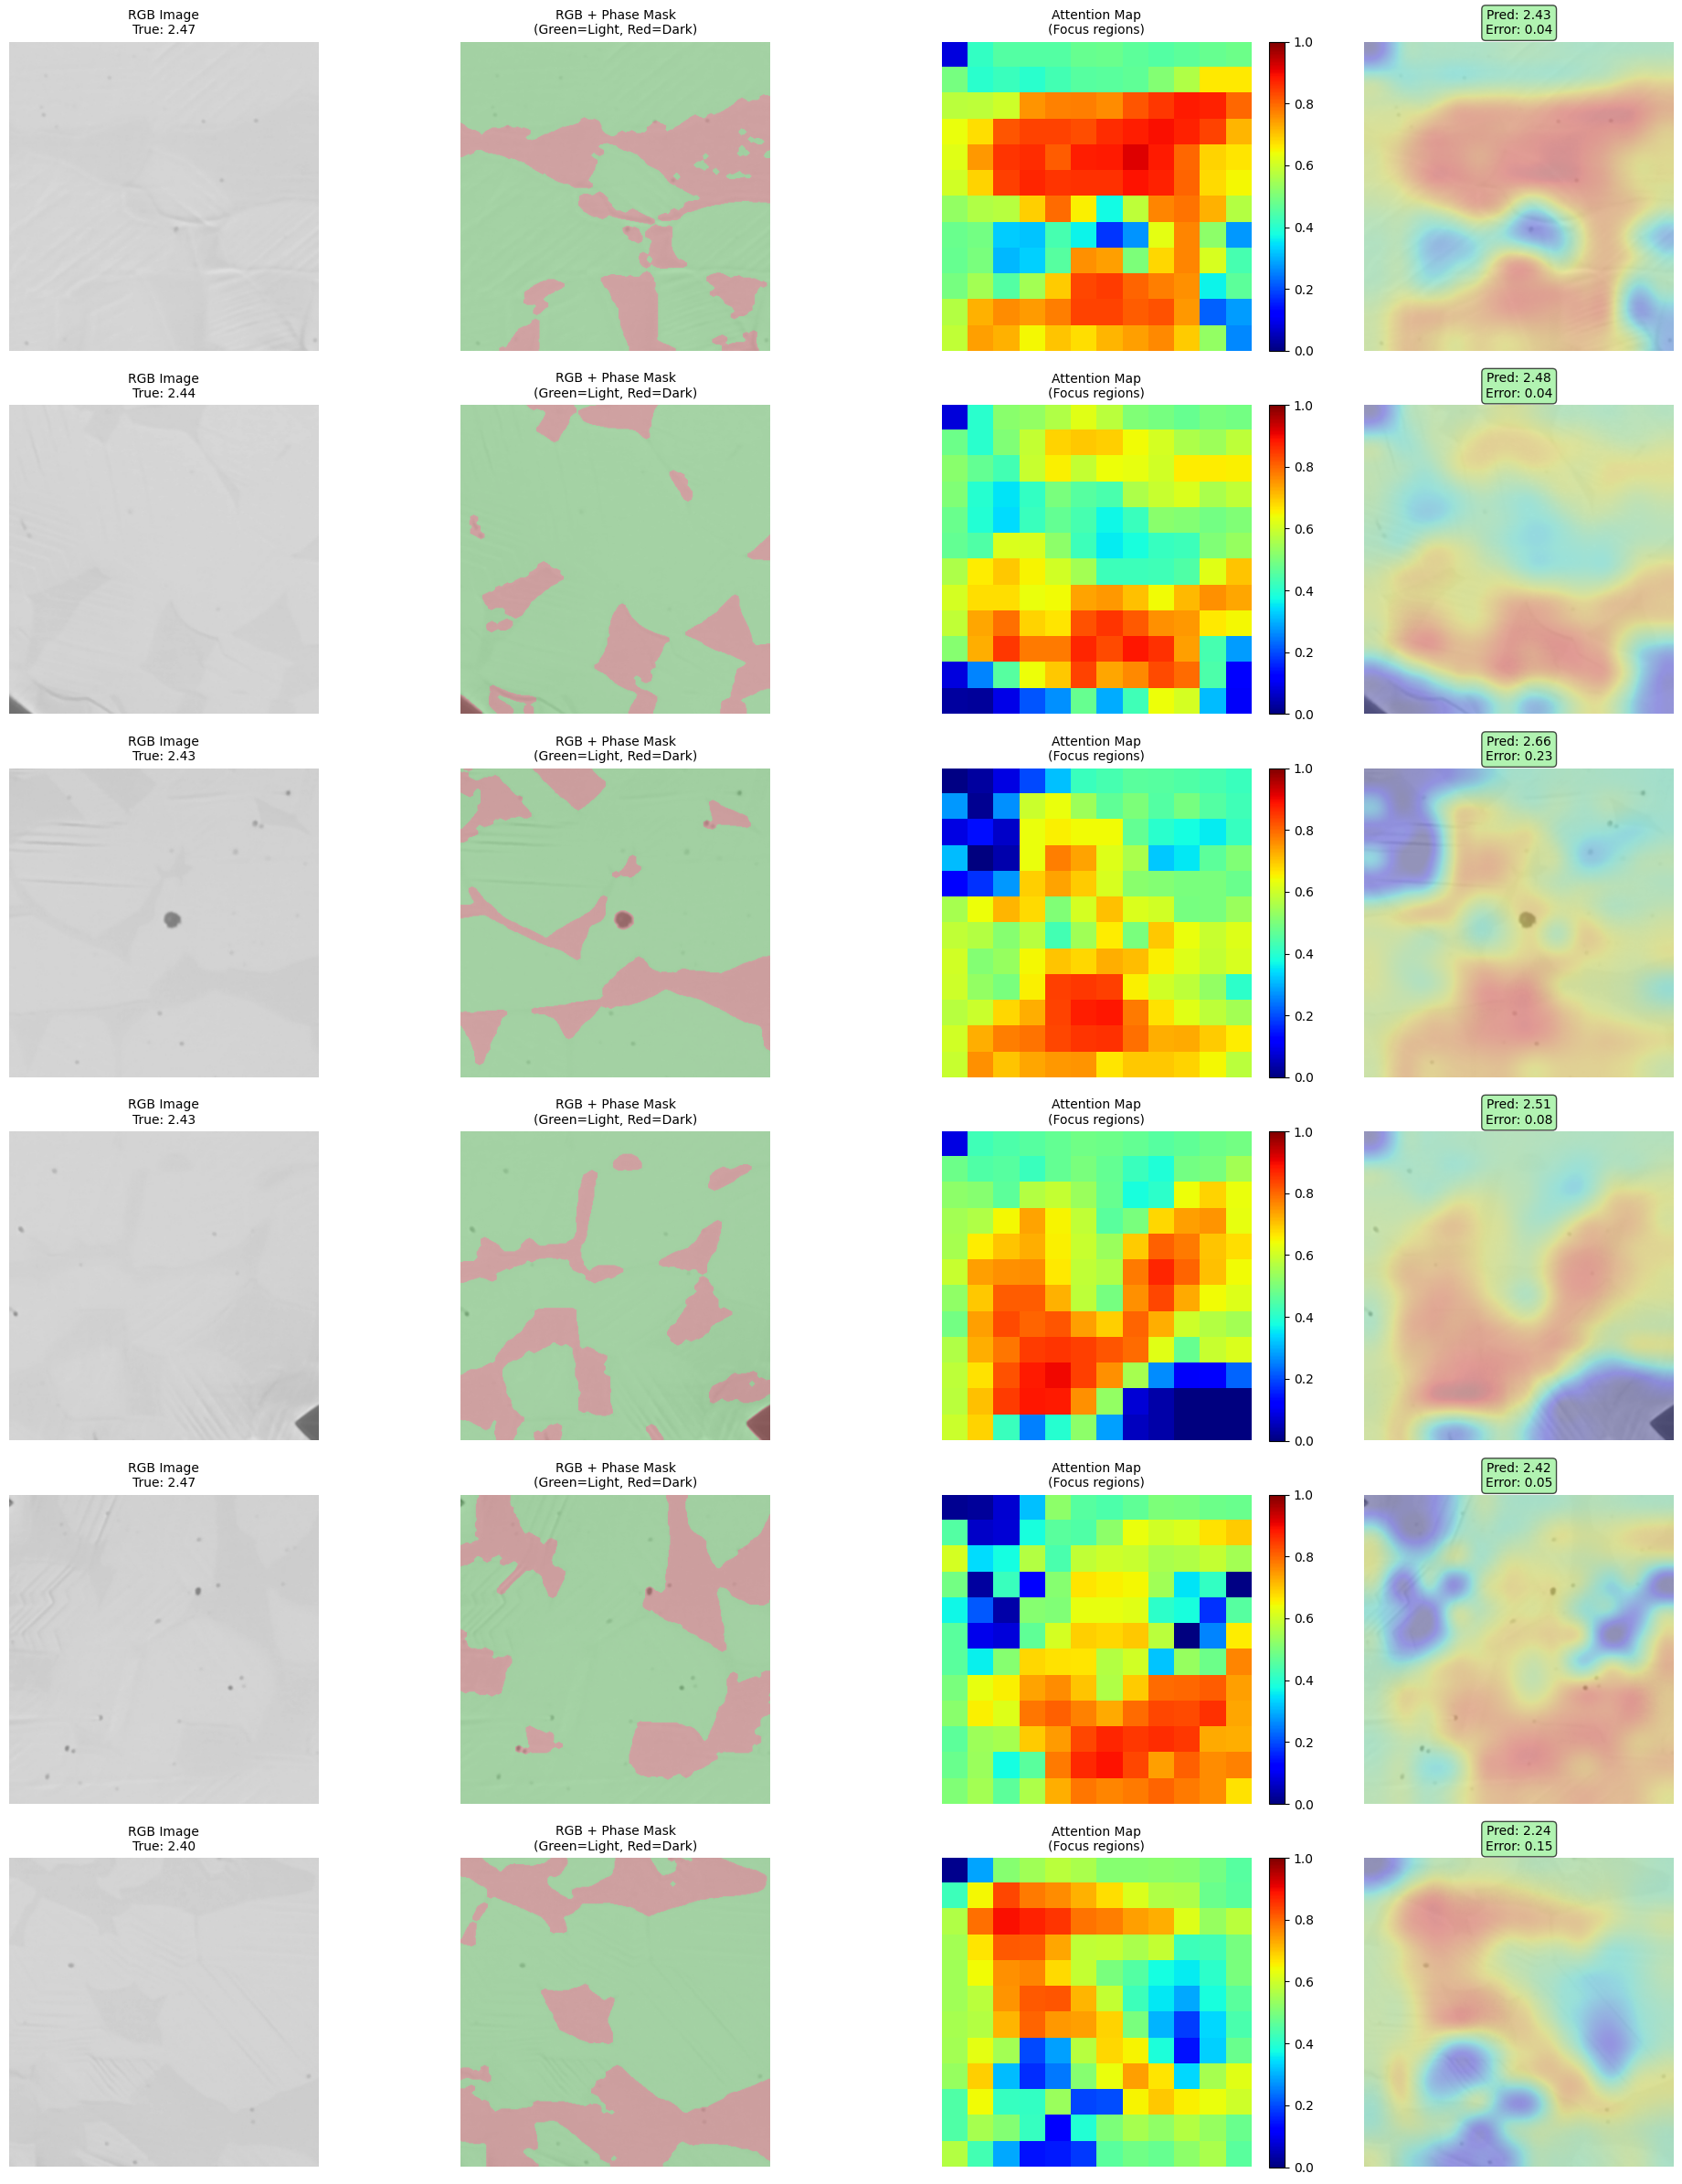

✅ Saved test predictions with attention maps and masks to runs/run_20260301_214006/test_predictions_with_attention_and_mask.png

✅ IM2PROP v2 Pipeline Complete!


In [29]:
# --- Test Evaluation with Attention Map Capture ---
def test_model_v2_with_attention(model, dataloader, device):
    """
    Evaluate v2 model on test set and capture attention maps.
    """
    model.eval()
    preds, trues, rgb_imgs, attention_maps = [], [], [], []
    
    # Hook to capture attention maps
    attention_outputs = []
    def attention_hook(module, input, output):
        # output is [B, 2048] after attention
        # We need to capture the attention map before GAP
        attention_outputs.append(module.attention(input[0]).detach().cpu())  # [B, 1, H, W]
    
    # Register hook on spatial attention module
    hook_handle = None
    for name, module in model.named_modules():
        if name == 'spatial_attention':
            hook_handle = module.attention.register_forward_hook(
                lambda m, i, o: attention_outputs.append(o.detach().cpu())
            )
            break
    
    with torch.no_grad():
        for rgb_tiles, mask_tiles, phase_ratios, targets in tqdm(dataloader, desc="Testing with Attention"):
            rgb_tiles = rgb_tiles.to(device)
            mask_tiles = mask_tiles.to(device)
            phase_ratios = phase_ratios.to(device)
            targets = targets.to(device).unsqueeze(1)
            
            attention_outputs.clear()
            outputs = model(rgb_tiles, mask_tiles, phase_ratios)
            
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
            rgb_imgs.append(rgb_tiles.cpu().numpy())
            
            # Capture attention maps [B, 1, H, W]
            if attention_outputs:
                attention_maps.append(attention_outputs[-1].numpy())
    
    if hook_handle is not None:
        hook_handle.remove()
    
    preds_concat = np.concatenate(preds).squeeze()
    trues_concat = np.concatenate(trues).squeeze()
    imgs_concat = np.concatenate(rgb_imgs)
    attn_concat = np.concatenate(attention_maps) if attention_maps else None  # [N, 1, H, W]
    
    mse = np.mean((preds_concat - trues_concat) ** 2)
    mae = np.mean(np.abs(preds_concat - trues_concat))
    rmse = np.sqrt(mse)
    
    print("\n" + "="*60)
    print("Test Results (IM2PROP v2 with Attention Maps)")
    print("="*60)
    print(f"MSE  : {mse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    
    return preds_concat, trues_concat, imgs_concat, attn_concat


# Load best model and test
model_regressor_v2.load_state_dict(torch.load(run_dir / "best_regression_model_v2.pt", map_location=device))
model_regressor_v2 = model_regressor_v2.to(device)
model_regressor_v2.eval()

test_preds, test_trues, test_imgs, test_attention = test_model_v2_with_attention(model_regressor_v2, test_loader, device)

# Capture mask data during testing for visualization
def test_model_v2_with_masks(model, dataloader, device):
    """
    Evaluate v2 model on test set and capture both attention maps and masks.
    """
    model.eval()
    preds, trues, rgb_imgs, attention_maps, mask_tiles = [], [], [], [], []
    
    # Hook to capture attention maps
    attention_outputs = []
    def attention_hook(module, input, output):
        attention_outputs.append(module.attention(input[0]).detach().cpu())  # [B, 1, H, W]
    
    # Register hook on spatial attention module
    hook_handle = None
    for name, module in model.named_modules():
        if name == 'spatial_attention':
            hook_handle = module.attention.register_forward_hook(
                lambda m, i, o: attention_outputs.append(o.detach().cpu())
            )
            break
    
    with torch.no_grad():
        for rgb_tiles, masks, phase_ratios, targets in tqdm(dataloader, desc="Testing with Attention & Masks"):
            rgb_tiles = rgb_tiles.to(device)
            masks = masks.to(device)
            phase_ratios = phase_ratios.to(device)
            targets = targets.to(device).unsqueeze(1)
            
            attention_outputs.clear()
            outputs = model(rgb_tiles, masks, phase_ratios)
            
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
            rgb_imgs.append(rgb_tiles.cpu().numpy())
            mask_tiles.append(masks.cpu().numpy())
            
            # Capture attention maps [B, 1, H, W]
            if attention_outputs:
                attention_maps.append(attention_outputs[-1].numpy())
    
    if hook_handle is not None:
        hook_handle.remove()
    
    preds_concat = np.concatenate(preds).squeeze()
    trues_concat = np.concatenate(trues).squeeze()
    imgs_concat = np.concatenate(rgb_imgs)
    masks_concat = np.concatenate(mask_tiles)
    attn_concat = np.concatenate(attention_maps) if attention_maps else None
    
    return preds_concat, trues_concat, imgs_concat, masks_concat, attn_concat

# Re-run test to get masks
test_preds, test_trues, test_imgs, test_masks, test_attention = test_model_v2_with_masks(model_regressor_v2, test_loader, device)

# --- Visualization with Attention Maps and Masks (using parameters) ---
def show_predictions_with_attention_and_mask(imgs, trues, preds, attention_maps, masks, num_samples=NUM_VIZ_SAMPLES, max_per_row=VIZ_COLS):
    """
    Visualize RGB images, masks overlay, attention maps, and predictions.
    Uses ATTENTION_ALPHA, HEATMAP_ALPHA, and HEATMAP_CMAP from parameters.
    
    imgs: [N, 3, H, W] normalized
    trues: [N]
    preds: [N]
    attention_maps: [N, 1, H, W] normalized to [0, 1]
    masks: [N, 1, H, W] normalized to [0, 1]
    """
    idxs = np.random.choice(len(imgs), num_samples, replace=False)
    rows = num_samples
    cols = 4  # RGB, RGB+Mask, Attention, Overlay
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows*4))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for n, i in enumerate(idxs):
        # Column 0: Original RGB Image
        ax = axes[n, 0]
        rgb_img = np.transpose(imgs[i], (1, 2, 0)).astype(np.float32)
        ax.imshow(rgb_img)
        ax.set_title(f"RGB Image\nTrue: {trues[i]:.2f}", fontsize=10)
        ax.axis('off')
        
        # Column 1: RGB with Mask Overlay
        ax = axes[n, 1]
        mask = masks[i, 0]  # [H, W]
        # Threshold mask to binary (255 = light phase = white, 0 = dark phase)
        mask_binary = (mask > 0.5).astype(np.float32)
        # Create mask overlay (light phase in red/yellow, dark phase transparent)
        mask_colored = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.float32)
        mask_colored[mask_binary == 1] = [0.2, 0.8, 0.2]  # Light green for light phase
        mask_colored[mask_binary == 0] = [0.8, 0.2, 0.2]  # Light red for dark phase
        # Blend with RGB
        rgb_with_mask = 0.7 * rgb_img + 0.3 * mask_colored
        ax.imshow(rgb_with_mask)
        ax.set_title(f"RGB + Phase Mask\n(Green=Light, Red=Dark)", fontsize=10)
        ax.axis('off')
        
        # Column 2: Attention Map
        ax = axes[n, 2]
        attn = attention_maps[i, 0]  # [H, W]
        im = ax.imshow(attn, cmap=HEATMAP_CMAP, vmin=0, vmax=1)
        ax.set_title(f"Attention Map\n(Focus regions)", fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Column 3: Attention Overlay on RGB
        ax = axes[n, 3]
        # Upscale attention map from (12, 12) to match RGB size (384, 384)
        attn_resized = cv2.resize(attn, (rgb_img.shape[1], rgb_img.shape[0]), interpolation=cv2.INTER_CUBIC)
        cmap_func = plt.get_cmap(HEATMAP_CMAP)
        attn_colored = cmap_func(attn_resized)[:, :, :3]  # [384, 384, 3]
        overlay = (1 - ATTENTION_ALPHA) * rgb_img + ATTENTION_ALPHA * attn_colored
        ax.imshow(overlay)
        ax.set_title(f"Pred: {preds[i]:.2f}\nError: {abs(trues[i] - preds[i]):.2f}", fontsize=10, 
                    bbox=dict(boxstyle='round', facecolor='yellow' if abs(trues[i] - preds[i]) > 1 else 'lightgreen', alpha=0.7))
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(run_dir / "test_predictions_with_attention_and_mask.png", dpi=200, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved test predictions with attention maps and masks to {run_dir}/test_predictions_with_attention_and_mask.png")


show_predictions_with_attention_and_mask(test_imgs, test_trues, test_preds, test_attention, test_masks)

print(f"\n✅ IM2PROP v2 Pipeline Complete!")


In [30]:
# Verify v2 model with all three inputs (RGB, mask, phase_ratios)
rgb_tile, mask_tile, phase_ratios, target = next(iter(train_loader))
with torch.no_grad():
    preds = model_regressor_v2(rgb_tile.to(device), mask_tile.to(device), phase_ratios.to(device))
    preds = preds.cpu().squeeze()
print("targets range:", target.min().item(), target.max().item())   
print("preds   range:", preds.min().item(), preds.max().item())


targets range: 2.38700008392334 2.4769999980926514
preds   range: 2.2697181701660156 2.6624670028686523


In [40]:
# Create mapping_inference folder for storing extracted masks
MAPPING_INFERENCE_DIR = Path('dss_2205/mapping_inference/')
MAPPING_INFERENCE_DIR.mkdir(exist_ok=True, parents=True)

def generate_sliding_window_heatmap_v2(
    model, 
    image_path, 
    crop_size=None,            # Window size (if None, uses SLIDING_WINDOW_CROP_SIZE)
    stride=None,               # Step size (if None, uses SLIDING_WINDOW_STRIDE)
    model_input_size=None,     # Model input size (if None, uses SLIDING_WINDOW_INPUT_SIZE)
    mode=None,                 # 'overlapping' or 'non-overlapping' (if None, uses SLIDING_WINDOW_MODE)
    device='cpu', 
    transform=None
):
    """
    Slides a window over the image, extracts phase masks on-the-fly, computes phase ratios, and predicts.
    For dual-branch v2 model: requires (rgb_patch, mask_patch, phase_ratios).
    Stores extracted masks in mapping_inference folder.
    
    CONSTRAINTS:
    - crop_size MUST equal model_input_size (avoids interpolation artifacts)
    - For 'overlapping' mode: stride must be < crop_size
    - For 'non-overlapping' mode: stride must equal crop_size
    """
    model.eval()
    
    # ── Use Global Parameters if Not Provided ──
    if crop_size is None:
        crop_size = SLIDING_WINDOW_CROP_SIZE
    if stride is None:
        stride = SLIDING_WINDOW_STRIDE
    if model_input_size is None:
        model_input_size = SLIDING_WINDOW_INPUT_SIZE
    if mode is None:
        mode = SLIDING_WINDOW_MODE
    
    # ── Validation: crop_size MUST equal model_input_size ──
    if crop_size != model_input_size:
        raise ValueError(
            f"❌ CONSTRAINT VIOLATED: crop_size must equal model_input_size!\n"
            f"   crop_size: {crop_size}\n"
            f"   model_input_size: {model_input_size}\n"
            f"   Reason: Resizing crops causes interpolation artifacts. "
            f"Set crop_size = model_input_size = PATCH_SIZE ({PATCH_SIZE})"
        )
    
    # ── Validation: mode-based stride logic ──
    crop_w, crop_h = crop_size
    if mode == 'overlapping':
        if stride >= crop_w:
            raise ValueError(
                f"❌ MODE VIOLATION: 'overlapping' mode requires stride < crop_size!\n"
                f"   stride: {stride}\n"
                f"   crop_size: {crop_size}\n"
                f"   For overlapping, try stride <= {crop_w // 2} (50% overlap)"
            )
    elif mode == 'non-overlapping':
        if stride != crop_w:
            raise ValueError(
                f"❌ MODE VIOLATION: 'non-overlapping' mode requires stride == crop_size!\n"
                f"   stride: {stride}\n"
                f"   crop_size: {crop_size}\n"
                f"   For non-overlapping, set stride = {crop_w}"
            )
    else:
        raise ValueError(f"❌ Unknown mode: '{mode}'. Must be 'overlapping' or 'non-overlapping'")
    
    # 1. Load Image
    img = Image.open(image_path).convert("RGB")
    img_bgr = cv2.imread(str(image_path))
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    orig_w, orig_h = img.size
    
    # 2. Padding Logic
    if orig_w < crop_w or orig_h < crop_h:
        cols = 1
        rows = 1
        target_w = max(orig_w, crop_w)
        target_h = max(orig_h, crop_h)
    else:
        cols = math.ceil((orig_w - crop_w) / stride) + 1
        rows = math.ceil((orig_h - crop_h) / stride) + 1
        target_w = (cols - 1) * stride + crop_w
        target_h = (rows - 1) * stride + crop_h

    padded_img = Image.new("RGB", (target_w, target_h), (0, 0, 0))
    padded_img.paste(img, (0, 0))
    
    padded_gray = np.zeros((target_h, target_w), dtype=np.uint8)
    padded_gray[:orig_h, :orig_w] = img_gray
    
    print(f"Original: {orig_w}x{orig_h} | Crop: {crop_size} | Stride: {stride}")
    print(f"Model Input: {model_input_size}")
    print(f"Heatmap Grid: {rows}x{cols}")
    print(f"Extracting phase masks on-the-fly...")

    heatmap = np.zeros((rows, cols))
    
    resize_transform = transforms.Resize(model_input_size, interpolation=transforms.InterpolationMode.BICUBIC)
    to_tensor = transforms.ToTensor()

    with torch.no_grad():
        for r in range(rows):
            for c in range(cols):
                # Calculate window coordinates
                left = c * stride
                top = r * stride
                right = min(left + crop_w, target_w)
                bottom = min(top + crop_h, target_h)
                
                # --- Extract RGB patch ---
                rgb_patch = padded_img.crop((left, top, right, bottom))
                
                # --- Extract phase mask patch on-the-fly ---
                gray_patch = padded_gray[top:bottom, left:right]
                
                # Apply CV pipeline to extract mask
                gray_patch_med = cv2.medianBlur(gray_patch, MEDIAN_K)
                bg = cv2.GaussianBlur(gray_patch_med, (0, 0), BG_SIGMA).astype(np.float32)
                bg = np.clip(bg, 1, None)
                gray_patch_norm = (gray_patch_med.astype(np.float32) / bg * 128).clip(0, 255).astype(np.uint8)
                clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID)
                gray_patch_clahe = clahe.apply(gray_patch_norm)
                gray_patch_smooth = cv2.GaussianBlur(gray_patch_clahe, GAUSS_K, GAUSS_SIG)
                
                otsu_val, mask_patch = cv2.threshold(gray_patch_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                
                # Morphological cleaning
                open_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (OPEN_K, OPEN_K))
                close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (CLOSE_K, CLOSE_K))
                mask_patch = cv2.morphologyEx(mask_patch, cv2.MORPH_OPEN, open_kernel, iterations=OPEN_IT)
                mask_patch = cv2.morphologyEx(mask_patch, cv2.MORPH_CLOSE, close_kernel, iterations=CLOSE_IT)
                
                # Save extracted mask
                mask_filename = MAPPING_INFERENCE_DIR / f"mask_r{r:03d}_c{c:03d}.png"
                cv2.imwrite(str(mask_filename), mask_patch)
                
                # --- Compute phase ratios from extracted mask ---
                light_pixels = np.sum(mask_patch == 255)
                dark_pixels = np.sum(mask_patch == 0)
                total_pixels = mask_patch.size
                light_ratio = (light_pixels / total_pixels) if total_pixels > 0 else 0.5
                dark_ratio = (dark_pixels / total_pixels) if total_pixels > 0 else 0.5
                
                # --- Prepare tensors ---
                if transform:
                    rgb_tensor = transform(rgb_patch)
                else:
                    rgb_resized = resize_transform(rgb_patch)
                    rgb_tensor = to_tensor(rgb_resized)
                
                # Resize mask to match input size
                mask_patch_resized = cv2.resize(mask_patch, model_input_size, interpolation=cv2.INTER_NEAREST)
                mask_tensor = torch.from_numpy(mask_patch_resized.astype(np.float32) / 255.0).unsqueeze(0)
                
                # Phase ratios tensor
                phase_ratios_tensor = torch.tensor([light_ratio, dark_ratio], dtype=torch.float32)
                
                # --- Predict ---
                rgb_batch = rgb_tensor.unsqueeze(0).to(device)
                mask_batch = mask_tensor.unsqueeze(0).to(device)
                phase_batch = phase_ratios_tensor.unsqueeze(0).to(device)
                
                pred = model(rgb_batch, mask_batch, phase_batch)
                heatmap[r, c] = pred.cpu().item()
                
    return heatmap, padded_img

def plot_heatmap_overlay(heatmap, original_image, alpha=HEATMAP_ALPHA, cmap=HEATMAP_CMAP):
    """
    Plots the original image side-by-side with the heatmap overlay using BICUBIC interpolation.
    Uses HEATMAP_ALPHA and HEATMAP_CMAP from parameters.
    """
    if heatmap is None:
        return

    w, h = original_image.size
    vmin, vmax = np.min(heatmap), np.max(heatmap)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original Image
    ax[0].imshow(original_image)
    ax[0].set_title(f"Original Image ({w}x{h})")
    ax[0].axis('off')
    
    # Heatmap Overlay
    ax[1].imshow(original_image)
    
    # interpolation='bicubic'
    im = ax[1].imshow(heatmap, cmap=cmap, alpha=alpha, extent=[0, w, h, 0], interpolation='bicubic')
    
    ax[1].set_title(f"Prediction Heatmap\nMin: {vmin:.2f} | Max: {vmax:.2f}")
    ax[1].axis('off')
    
    cbar = plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
    cbar.set_label('Predicted Value')
    
    plt.tight_layout()
    plt.show()

def save_heatmap_only(heatmap, original_image, save_path, alpha=HEATMAP_ALPHA, cmap=HEATMAP_CMAP):
    """
    Generates and saves ONLY the heatmap overlay with the scalebar (no side-by-side).
    Uses HEATMAP_ALPHA and HEATMAP_CMAP from parameters.
    """
    w, h = original_image.size
    vmin, vmax = np.min(heatmap), np.max(heatmap)
    
    # Create a single figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Background image
    ax.imshow(original_image)
    
    # Overlay
    im = ax.imshow(heatmap, cmap=cmap, alpha=alpha, extent=[0, w, h, 0], interpolation='bicubic')
    ax.axis('off') # Hide axes ticks

    ax.set_title(f"Prediction Heatmap\nMin: {vmin:.2f} GPa | Max: {vmax:.2f} GPa")
    ax.axis('off')
    
    # Scalebar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Predicted Value (GPa)')
    
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"Saved heatmap only to: {save_path}")


Sliding Window Inference
Using image: dss_2205/10X.png
✅ Image found
Sliding Window Parameters:
  Crop size: (384, 384)
  Stride: 192
  Input size: (384, 384)
  Output: dss_2205/mapping_inference

Original: 1920x1080 | Crop: (384, 384) | Stride: 192
Model Input: (384, 384)
Heatmap Grid: 5x9
Extracting phase masks on-the-fly...

✅ Heatmap generated: (5, 9)
✅ Extracted masks saved to: dss_2205/mapping_inference
   Predicted hardness range: 2.85 - 3.07


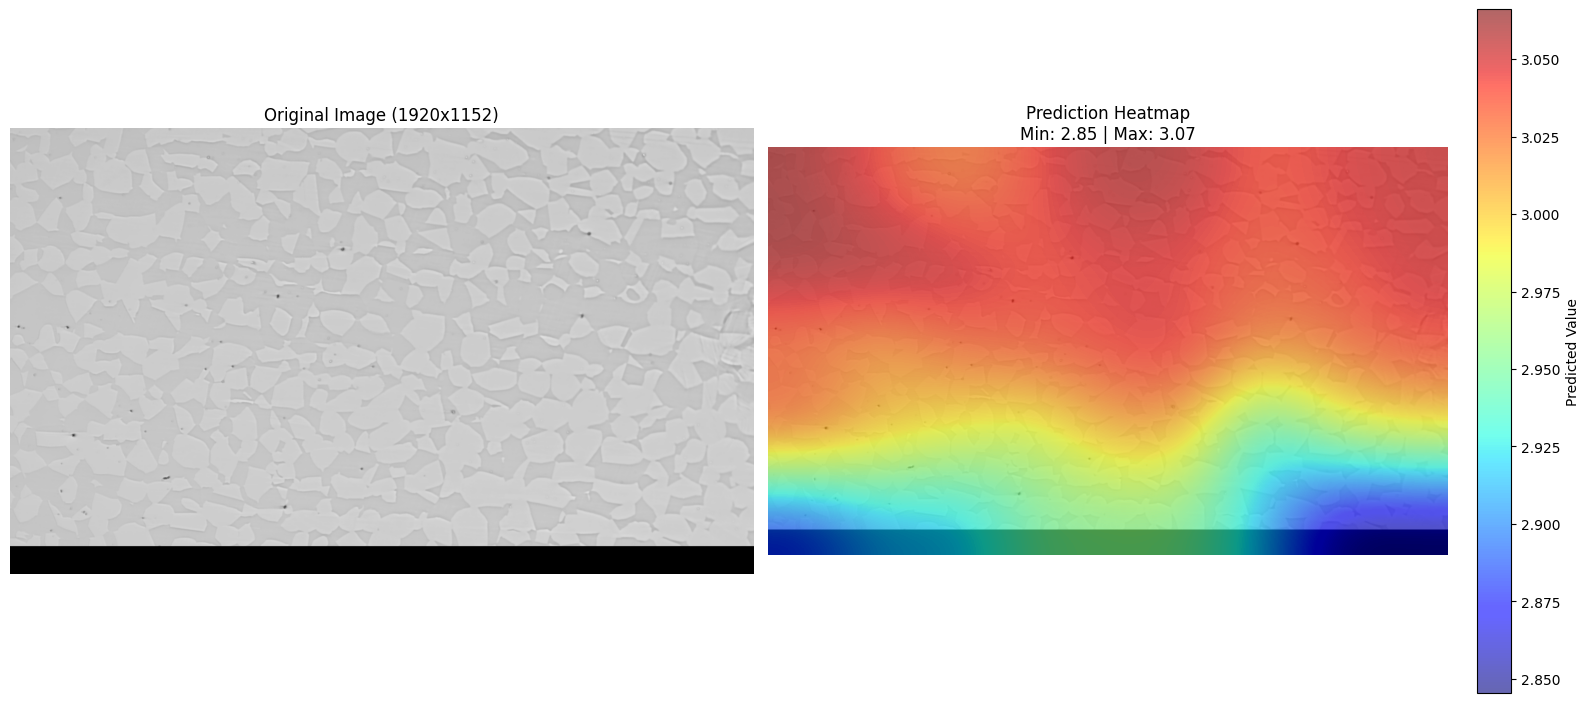

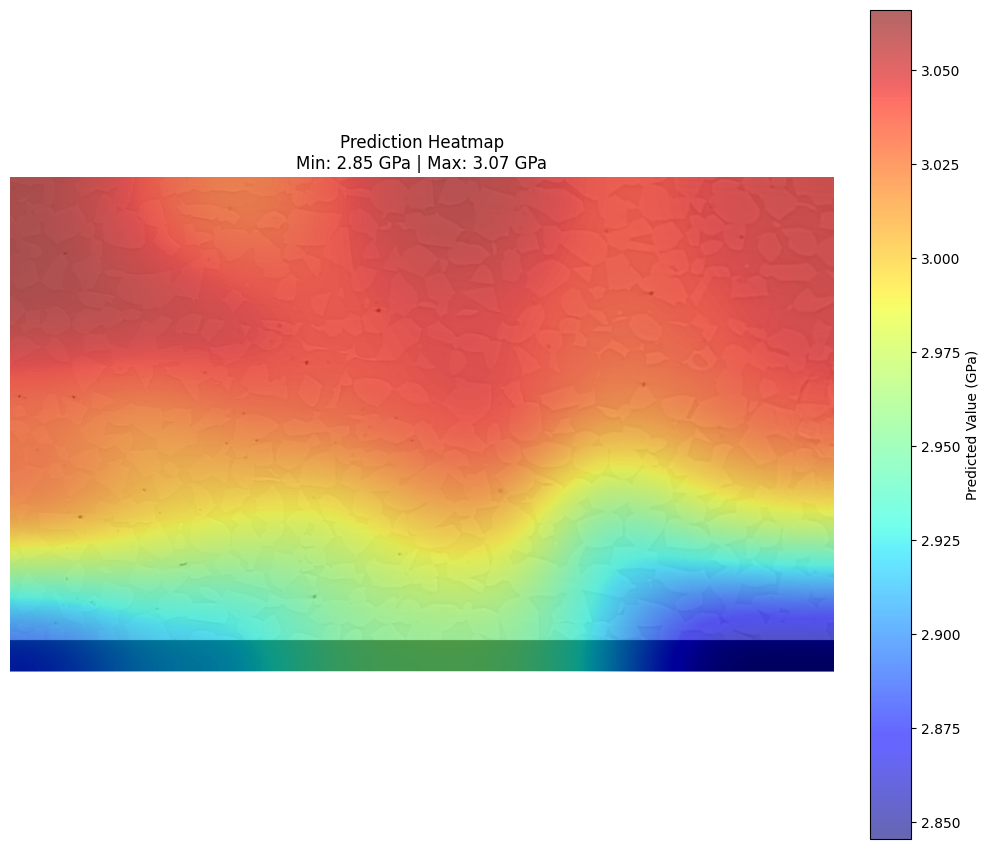

Saved heatmap only to: dss_2205/mapping_inference/sliding_window_heatmap.png


In [41]:
# Use inference image path from parameters
if INFERENCE_IMAGE_PATH:
    inference_image_path = Path(INFERENCE_IMAGE_PATH)
else:
    # Default to first test image if not specified
    test_image_name = test_df.iloc[0]['image_id']
    inference_image_path = IMAGE_DIR / f"{test_image_name}.png"

print(f"\n{'='*60}")
print(f"Sliding Window Inference")
print(f"{'='*60}")
print(f"Using image: {inference_image_path}")

if not inference_image_path.exists():
    print(f"❌ Image not found: {inference_image_path}")
else:
    print(f"✅ Image found")
    print(f"Sliding Window Parameters:")
    print(f"  Crop size: {SLIDING_WINDOW_CROP_SIZE}")
    print(f"  Stride: {SLIDING_WINDOW_STRIDE}")
    print(f"  Input size: {SLIDING_WINDOW_INPUT_SIZE}")
    print(f"  Output: {MAPPING_INFERENCE_DIR}")
    print(f"{'='*60}\n")
    
    # 1. Run the Heatmap Generator with v2 model
    heatmap_grid, img_obj = generate_sliding_window_heatmap_v2(
        model=model_regressor_v2, 
        image_path=str(inference_image_path),
        
        crop_size=SLIDING_WINDOW_CROP_SIZE,
        stride=SLIDING_WINDOW_STRIDE,
        model_input_size=SLIDING_WINDOW_INPUT_SIZE,
        mode=SLIDING_WINDOW_MODE,
        
        device=device,
        transform=test_augmentations
    )
    
    print(f"\n✅ Heatmap generated: {heatmap_grid.shape}")
    print(f"✅ Extracted masks saved to: {MAPPING_INFERENCE_DIR}")
    print(f"   Predicted hardness range: {np.min(heatmap_grid):.2f} - {np.max(heatmap_grid):.2f}")
    
    # 2. Visualize
    plot_heatmap_overlay(heatmap_grid, img_obj)
    
    # 3. Save
    save_heatmap_only(heatmap_grid, img_obj, save_path=MAPPING_INFERENCE_DIR / "sliding_window_heatmap.png")